In [71]:
import os
import logging
from contextlib import contextmanager, redirect_stderr, redirect_stdout
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score


In [72]:
@contextmanager
def suppress_stdout_stderr():
	"""A context manager that redirects stdout and stderr to devnull"""
	with open(os.devnull, 'w') as fnull:
		with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
			yield (err, out)

#

In [73]:
def load_dataset(path):
	"""
	Carrega el dataset de registres dels ciclistes

	arguments:
		path -- dataset

	Returns: dataframe
	"""
	return pd.read_csv(path, delimiter=',')

In [74]:
def EDA(df):
	"""
	Exploratory Data Analysis del dataframe

	arguments:
		df -- dataframe

	Returns: None
	"""
	# TODO
	logging.debug('\n%s', df.shape)#Número de filas y columnas
	logging.debug('\n%s', df[:5])# 5 primeras filas del dataframe
	logging.debug('\n%s', df.columns) # lisa los nombres de las columnas
	logging.debug('\n%s', df.info()) # Info resumen de la estructura del DataFrame
	

In [75]:
def clean(df):
	"""
	Elimina les columnes que no són necessàries per a l'anàlisi dels clústers

	arguments:
		df -- dataframe

	Returns: dataframe
	"""
	# eliminem les columnes que no interessen
	df = df.drop('id', axis=1)
	df = df.drop('tt', axis=1)
	logging.debug('\nDataframe:\n%s\n...', df[:3])

	return df

In [76]:
path_dataset = 'data/ciclistes.csv'
ciclistes_data = load_dataset(path_dataset)

In [77]:
parking_data

,tp,tb
0,3112,1860
1,3513,1623
2,3519,1318
3,3633,1266
4,3286,1955
...,...,...
3995,4373,2077
3996,4583,2519
3997,4188,1894
3998,4723,2085


In [78]:
EDA(ciclistes_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4000 non-null   int64 
 1   Tipus   4000 non-null   object
 2   tp      4000 non-null   int64 
 3   tb      4000 non-null   int64 
 4   tt      4000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 156.4+ KB


In [79]:
print(parking_data.columns)

Index(['tp', 'tb'], dtype='object')


In [80]:
ciclistes_data = clean(ciclistes_data)
print ("Dataset Cleaned", ciclistes_data)

Dataset Cleaned      Tipus    tp    tb
0     BEBB  3112  1860
1     BEBB  3513  1623
2     BEBB  3519  1318
3     BEBB  3633  1266
4     BEBB  3286  1955
...    ...   ...   ...
3995  MEMB  4373  2077
3996  MEMB  4583  2519
3997  MEMB  4188  1894
3998  MEMB  4723  2085
3999  MEMB  4554  2465

[4000 rows x 3 columns]


In [81]:
print(ciclistes_data.columns)

Index(['Tipus', 'tp', 'tb'], dtype='object')


In [82]:
def extract_true_labels(df):
    """
    Guarda les etiquetes dels ciclistes (BEBB, ...) i elimina la columna 'Tipus' del dataframe.

    arguments:
        df -- dataframe

    Returns:
        true_labels (numpy ndarray): etiquetes úniques (labels) dels ciclistes
    """
    # Guardar les etiquetes úniques
    true_labels = df['Tipus'].to_numpy()
    
    # Eliminar la columna 'Tipus' del dataframe
    df.drop('Tipus', axis=1, inplace=True)
    
    logging.debug('\nEtiquetes úniques: %s\n', true_labels)
    return true_labels

In [83]:
def visualitzar_pairplot(df):
	"""
	Genera una imatge combinant entre sí tots els parells d'atributs.
	Serveix per apreciar si es podran trobar clústers.

	arguments:
		df -- dataframe

	Returns: None
	"""
	# TODO
	sns.pairplot(df)
	try:
		os.makedirs(os.path.dirname('img/'))
	except FileExistsError:
		pass
	plt.savefig("img/pairplot.png")

In [84]:
true_labels = extract_true_labels(ciclistes_data)


In [85]:

true_labels

array(['BEBB', 'BEBB', 'BEBB', ..., 'MEMB', 'MEMB', 'MEMB'], dtype=object)

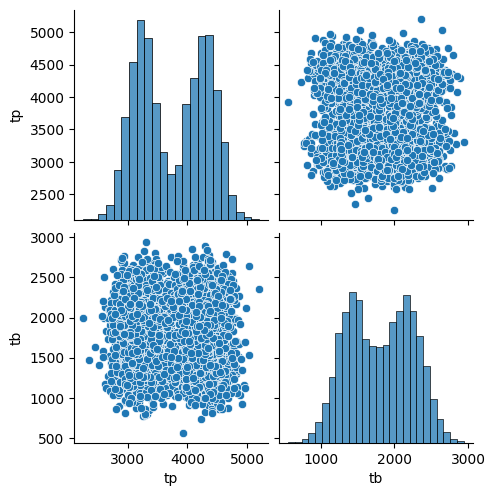

In [86]:
visualitzar_pairplot(ciclistes_data)


In [87]:
def clustering_kmeans(data, n_clusters=4):
	"""
	Crea el model KMeans de sk-learn, amb 4 clusters (estem cercant 4 agrupacions)
	Entrena el model

	arguments:
		data -- les dades: tp i tb

	Returns: model (objecte KMeans)
	"""
	# TODO
	model = KMeans(n_clusters=4, random_state=42)
	with suppress_stdout_stderr():
		model.fit(data)

	return model

In [88]:
clustering_model = clustering_kmeans(ciclistes_data)
clustering_model

KMeans(n_clusters=4, random_state=42)

In [89]:
	# guardem el model
with open('model/clustering_model.pkl', 'wb') as f:
  pickle.dump(clustering_model, f)
data_labels = clustering_model.labels_

In [90]:
data_labels

array([0, 2, 2, ..., 3, 3, 3], dtype=int32)

In [91]:
logging.info('\nHomogeneity: %.3f', homogeneity_score(true_labels, data_labels))
logging.info('Completeness: %.3f', completeness_score(true_labels, data_labels))
logging.info('V-measure: %.3f', v_measure_score(true_labels, data_labels))
with open('model/scores.pkl', 'wb') as f:
  pickle.dump({
  "h": homogeneity_score(true_labels, data_labels),
  "c": completeness_score(true_labels, data_labels),
  "v": v_measure_score(true_labels, data_labels)
  }, f)

In [ ]:
def visualitzar_clusters(data, labels):
	"""
	Visualitza els clusters en diferents colors. Provem diferents combinacions de parells d'atributs

	arguments:
		data -- el dataset sobre el qual hem entrenat
		labels -- l'array d'etiquetes a què pertanyen les dades (hem assignat les dades a un dels 4 clústers)

	Returns: None
	"""
	try:
		os.makedirs(os.path.dirname('img/'))
	except FileExistsError:
		pass

	fig = plt.figure()
	sns.scatterplot(x='tb', y='tp', data=data, hue=labels, palette="rainbow")
	plt.savefig("img/grafica1.png")
	fig.clf()
	#plt.show()


In [98]:
ciclistes_data

,tp,tb
0,3112,1860
1,3513,1623
2,3519,1318
3,3633,1266
4,3286,1955
...,...,...
3995,4373,2077
3996,4583,2519
3997,4188,1894
3998,4723,2085


In [101]:
visualitzar_clusters(ciclistes_data, data_labels)
ciclistes_data['label'] = clustering_model.labels_.tolist()
logging.debug('\nColumna label:\n%s', ciclistes_data[:5])

<Figure size 640x480 with 0 Axes>

In [102]:
ciclistes_data

,tp,tb,label
0,3112,1860,0
1,3513,1623,2
2,3519,1318,2
3,3633,1266,2
4,3286,1955,0
...,...,...,...
3995,4373,2077,3
3996,4583,2519,3
3997,4188,1894,3
3998,4723,2085,3


In [103]:
def associar_clusters_patrons(tipus, model):
	"""
	Associa els clústers (labels 0, 1, 2, 3) als patrons de comportament (BEBB, BEMB, MEBB, MEMB).
	S'han trobat 4 clústers però aquesta associació encara no s'ha fet.

	arguments:
	tipus -- un array de tipus de patrons que volem actualitzar associant els labels
	model -- model KMeans entrenat

	Returns: array de diccionaris amb l'assignació dels tipus als labels
	"""
	# proposta de solució

	dicc = {'tp':0, 'tb': 1}

	logging.info('Centres:')
	for j in range(len(tipus)):
		logging.info('{:d}:\t(tp: {:.1f}\ttb: {:.1f})'.format(j, model.cluster_centers_[j][dicc['tp']], model.cluster_centers_[j][dicc['tb']]))

	# Procés d'assignació
	ind_label_0 = -1
	ind_label_1 = -1
	ind_label_2 = -1
	ind_label_3 = -1

	suma_max = 0
	suma_min = 50000

	for j, center in enumerate(clustering_model.cluster_centers_):
		suma = round(center[dicc['tp']], 1) + round(center[dicc['tb']], 1)
		if suma_max < suma:
			suma_max = suma
			ind_label_3 = j
		if suma_min > suma:
			suma_min = suma
			ind_label_0 = j

	tipus[0].update({'label': ind_label_0})
	tipus[3].update({'label': ind_label_3})

	lst = [0, 1, 2, 3]
	lst.remove(ind_label_0)
	lst.remove(ind_label_3)

	if clustering_model.cluster_centers_[lst[0]][0] < clustering_model.cluster_centers_[lst[1]][0]:
		ind_label_1 = lst[0]
		ind_label_2 = lst[1]
	else:
		ind_label_1 = lst[1]
		ind_label_2 = lst[0]

	tipus[1].update({'label': ind_label_1})
	tipus[2].update({'label': ind_label_2})

	logging.info('\nHem fet l\'associació')
	logging.info('\nTipus i labels:\n%s', tipus)
	return tipus

In [104]:
tipus = [{'name': 'BEBB'}, {'name': 'BEMB'}, {'name': 'MEBB'}, {'name': 'MEMB'}]
	
	
tipus = associar_clusters_patrons(tipus, clustering_model)
	# guardem la variable tipus
with open('model/tipus_dict.pkl', 'wb') as f:
	pickle.dump(tipus, f)
	logging.info('\nTipus i labels:\n%s', tipus)


In [107]:
def generar_informes(df, tipus):
	"""
	Generació dels informes a la carpeta informes/. Tenim un dataset de cotxes i 4 clústers, i generem
	4 fitxers de matrícules per cadascun dels clústers

	arguments:
		df -- dataframe
		tipus -- objecte que associa els patrons de comportament amb els labels dels clústers

	Returns: None
	"""
	ciclistes_label = [
		df[df['label'] == 0],
		df[df['label'] == 1],
		df[df['label'] == 2],
		df[df['label'] == 3]
	]

	try:
		os.makedirs(os.path.dirname('informes/'))
	except FileExistsError:
		pass

	for tip in tipus:
		fitxer = tip['name'].replace(' ', '_') + '.txt'
		foutput = open("informes/" + fitxer, "w")
		t = [t for t in tipus if t['name'] == tip['name']]
		ciclistes = ciclistes_label[t[0]['label']].index
		for ciclista in ciclistes:
			foutput.write(str(ciclista) + '\n')

		foutput.close()

	logging.info('\nS\'han generat els informes en la carpeta informes/')

In [108]:
generar_informes(ciclistes_data, tipus)
